In [3]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

In [4]:
# #Number of simulation
# n=109

# #choose between 'local' or 'dahu'
# where='dahu'


# #Reading the netcdf file


# if where=='local':
#     if n<10:
#         simu_name='outdir_000'+str(n)
#     elif n<100 and n>=10:
#         simu_name='outdir_00'+str(n)
#     Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

# elif where=='dahu':
#     simu_name='dahu_'+str(n)
#     Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

# else:
#     print('Error: where not recognized')
#     sys.exit()
# print('la simulation chargée est: ' + simu_name )
# print("depuis: "+where)

# filenames=['/vars.nc']



# dataset=nc.Dataset(Path+filenames[0])
# print(dataset.variables.keys())

# t=dataset.variables['time'][:]
# x=dataset.variables['x'][:]
# y=dataset.variables['y'][:]
# psi=dataset.variables['psi'][:,:,:,:]
# q=dataset.variables['q'][:,:,:,:]

# print("psi shape",psi.shape)
# #Lecture des paramètres :

# param=io.read_params(Path)
# print(param)
# f0= param['f0']
# beta=param['beta']
# hEkb=param['hEkb']
# dh=param['dh'][0]
# Lx=param['Lx']
# nx=param['NX']
# ny=param['NY']
# k_f=param['k_f']
# sigma_f=param['sigma_f']
# bc_fac=param['bc_fac']
# nu_hyper=param['nu_hyper']
# n_hyper=param['n_hyper']
# dt_out=param['dt_out']

la simulation chargée est: dahu_210
depuis: dahu
shape of psi : (437, 1025, 1025)
{'NX': 1024.0, 'NY': 1024.0, 'nl': 1.0, 'Lx': 6.2831855, 'f0': 2.0, 'beta': 0.66, 'k_f': 32.0, 'sigma_f': 0.02, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 0.0023, 'tend': 1576800000000.0, 'dt_out': 10.0}


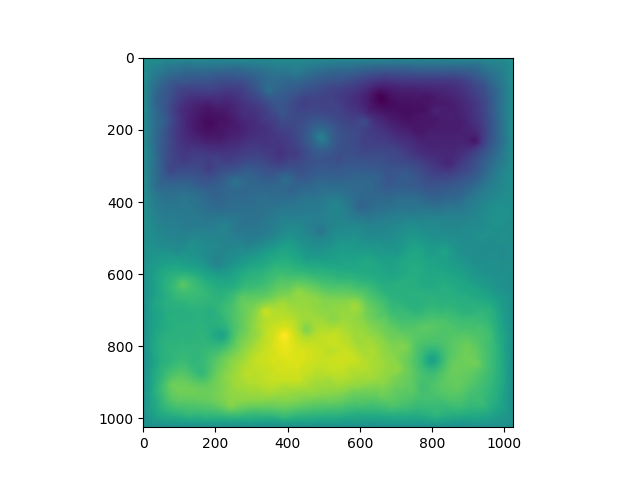

In [5]:


# Number of simulation
n = 210#901#70#6190#65

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [6]:

tim_sel=np.arange(40,len(t),1)
psi_data = psi[tim_sel, :, :]
q_data = q[tim_sel, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

if n_hyper==6:
    #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
    palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
    enstro_diss=-nu_hyper*palenstro_tot 

#Dans le cas ou l'hyper visocisté est égale à 4:
elif n_hyper==4:    

    enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

mean_enstro_diss=float(np.mean(enstro_diss[:]))
mean_energy_diss=float(np.mean(energy_diss[:]))
mean_energy_inj=float(np.mean(energy_inj[:]))

#computing the error of the energy dissipation
print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')


N= 1025 Nt= 397
(397, 1025, 1025)
(397, 1025, 1025)
N= 1025 Nt= 397
(397, 1025, 1025)
Error = -2.625000066313079 %
Energy_diss_drag/Energy_injected 94.656 %


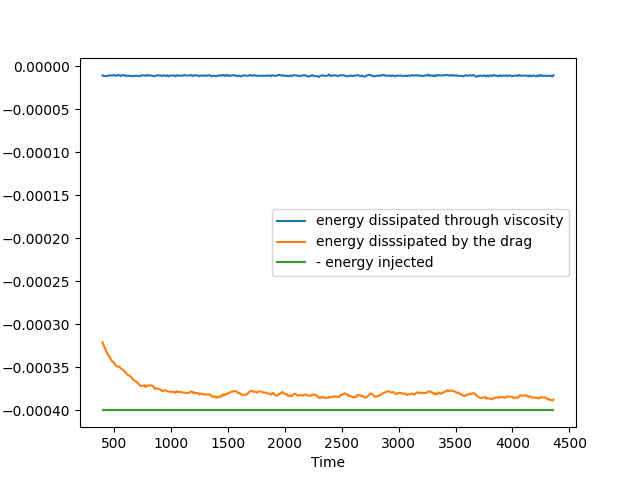

In [7]:

plt.figure()

plt.plot(t[tim_sel],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[tim_sel],energy_diss,label='energy disssipated by the drag')
plt.plot(t[tim_sel],-energy_inj,label='- energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
#plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()


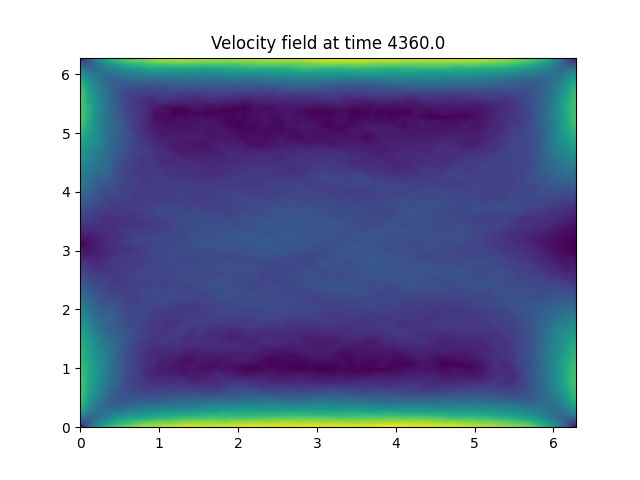

In [8]:
#Plotting the mean velocity field

time_start =100

psi_data = psi[-time_start:, :, :]
dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain


X,Y=np.meshgrid(x,y)

u,v=op.calc_uv(psi_data,dx,bc_fac=bc_fac)
U=np.sqrt(np.mean(u,axis=0)**2+np.mean(v,axis=0)**2)
plt.figure()
plt.pcolormesh(X,Y,U)
plt.title('Velocity field at time '+str(t[-1]))
plt.savefig('./figures/Velocity/Velocity_field_'+str(simu_name)+'.png')
plt.show()


(512,)


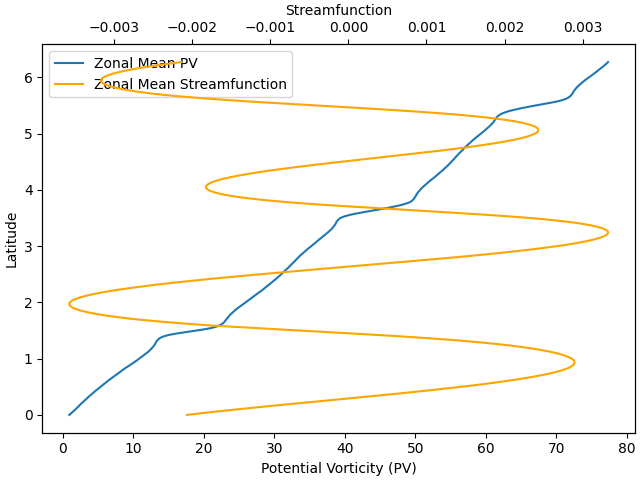

In [ ]:
time_start =1

tim_sel=np.arange(1400,len(t),1)
psi_data = psi[tim_sel, :, :]
q_data = q[tim_sel, :, :]
print(np.shape(y))

q_zonal_mean = np.mean(q_data, axis=2)  # Averaging over the longitude axis
Psi_zonal_mean = np.mean(psi_data, axis=2)



epsilon=sigma_f**2
r=f0*hEkb/(2*dh)

k_rhines = beta**0.5/(epsilon/r)**(1/4)
Lrh=np.pi*2/k_rhines

# plt.figure()
# plt.plot((np.mean((q_zonal_mean[time_start:, :]),axis=0)+beta*y) / (Lrh*np.sqrt(epsilon/r)) ,y,label='Zonal Mean PV')
# plt.plot(np.mean(Psi_zonal_mean[time_start:, :] ,axis=0)/(beta*Lx),y, label='Zonal Mean Streamfunction')
# plt.ylabel('Latitude')
# plt.xlabel('PV / Streamfunction')
# plt.legend()

# plt.savefig('./figures/PV_stair/Zonal_mean_'+str(simu_name)+'.png')  
fig, ax = plt.subplots(layout='constrained')

# First plot for Zonal Mean PV
line1, = ax.plot((np.mean((q_zonal_mean[time_start:, :]), axis=0) + beta * y) / (Lrh * np.sqrt(epsilon / r)), y, label='Zonal Mean PV')
ax.set_xlabel('Potential Vorticity (PV)')

# Second plot for Zonal Mean Streamfunction with a secondary x-axis
ax2 = ax.twiny()  # Use ax.twiny() instead of plt.gca().twiny() to link it directly
line2, = ax2.plot(np.mean(Psi_zonal_mean[time_start:, :], axis=0) / (beta * Lx), y, label='Zonal Mean Streamfunction', color='orange')
ax2.set_xlabel('Streamfunction')

# Set up the rest of the plot
ax.set_ylabel('Latitude')

# Combine the legends from both plots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

# Save and show the figure
plt.savefig('./figures/PV_stair/Staircase_simu' + str(simu_name) + '.png')
plt.show()



In [95]:
print(y)

[0.         0.01227185 0.02454369 0.03681554 0.04908739 0.06135923
 0.07363108 0.08590292 0.09817477 0.11044662 0.12271846 0.1349903
 0.14726216 0.159534   0.17180584 0.1840777  0.19634955 0.20862138
 0.22089323 0.23316509 0.24543692 0.25770876 0.2699806  0.28225246
 0.2945243  0.30679616 0.319068   0.33133984 0.3436117  0.35588354
 0.3681554  0.38042724 0.3926991  0.4049709  0.41724277 0.42951462
 0.44178647 0.45405832 0.46633017 0.478602   0.49087384 0.5031457
 0.5154175  0.5276894  0.5399612  0.5522331  0.5645049  0.5767768
 0.5890486  0.60132045 0.6135923  0.62586415 0.638136   0.65040785
 0.6626797  0.67495155 0.6872234  0.69949526 0.7117671  0.72403896
 0.7363108  0.7485826  0.7608545  0.7731263  0.7853982  0.79767
 0.8099418  0.8222137  0.83448553 0.8467574  0.85902923 0.8713011
 0.88357294 0.89584476 0.90811664 0.92038846 0.93266034 0.94493216
 0.957204   0.96947587 0.9817477  0.99401957 1.0062914  1.0185633
 1.030835   1.0431069  1.0553788  1.0676507  1.0799224  1.0921943
 1.1

NameError: name 'psi_mean' is not defined

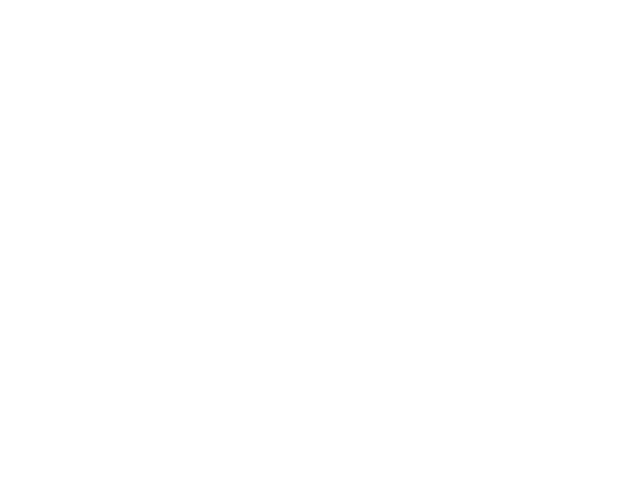

In [39]:
plt.figure()
plt.imshow(psi_mean,vmax=np.max(psi_mean))#+beta*Y)
plt.title('Mean Streamfunction of the simulation '+str(simu_name))
plt.savefig('./figures/jets/psi_mean_'+str(simu_name)+'.png')
plt.show()


In [26]:
#We plot the temporal mean streamfunction  and the temporal mean q
startt=0

#selecting an indice to avoid the boundary
indice_dep=int(0.03*nx)


q_mean = np.mean(q[startt:,0,indice_dep:-indice_dep,indice_dep:-indice_dep],axis=0)
psi_mean= np.mean(psi[startt:,0,indice_dep:-indice_dep,indice_dep:-indice_dep],axis=0)
X,Y=np.meshgrid(x[indice_dep:-indice_dep],y[indice_dep:-indice_dep])

plt.figure()
plt.scatter(psi_mean,q_mean+beta*Y)
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.savefig('./figures/mean_psi_q_'+str(simu_name)+'.png')
plt.show()

print(q_mean.shape)



IndexError: Too many indices for array

In [ ]:
tstart=0


#Computing the energy ratios
delta=Lx/nx

u,v=op.calc_uv(psi[tstart:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)

#Mean energy
energy_tot=np.mean(energy,axis=0)

#Energy of the mean zonal flow
energy_zonal=0.5*(np.mean(u,axis=0)**2)

#Energy of the mean flow
energy_mean=0.5*(np.mean(np.sqrt(u**2+v**2),axis=0)**2)


ratioUzonUtot=energy_zonal/energy_tot
ratioUmeanUtot=energy_mean/energy_tot


plt.figure()
plt.imshow(ratioUzonUtot, cmap='jet')

plt.colorbar()
plt.title('Ratio of the energy of the zonal flow to the total energy')

plt.show()



NameError: name 'Lx' is not defined

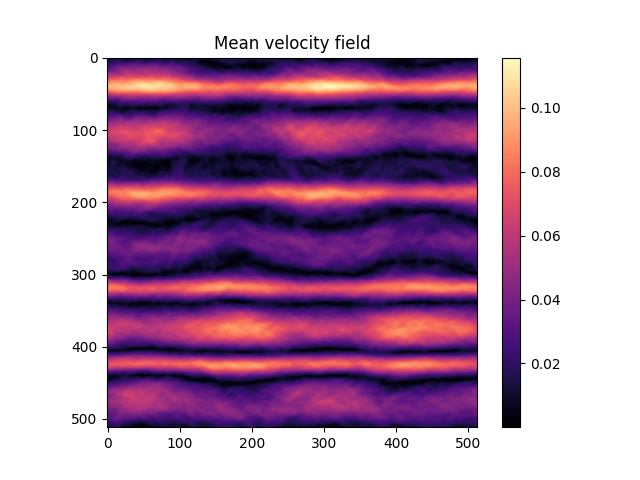

In [42]:
#plotting the average velocity field
u_mean=np.mean(u,axis=0)
v_mean=np.mean(v,axis=0)
U=np.sqrt(u_mean**2+v_mean**2)

plt.figure()
plt.imshow(U,cmap='magma')
plt.colorbar()
plt.title('Mean velocity field')
plt.show()

NameError: name 'ratioUmeanUtot' is not defined

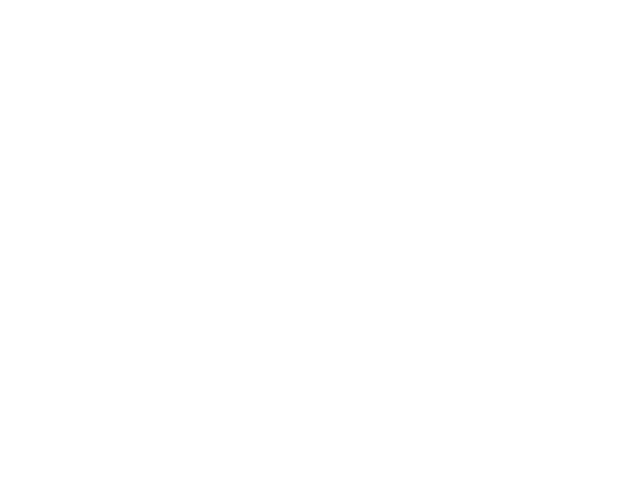

In [43]:
plt.figure()
plt.imshow(ratioUmeanUtot, cmap='jet',vmax=1)
plt.colorbar()
plt.title('Energy of the mean flow/Total Energy')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('./figures/jets/Energy_ratio_'+str(simu_name)+'.png')
plt.show()

# Measuring the size of the border jets

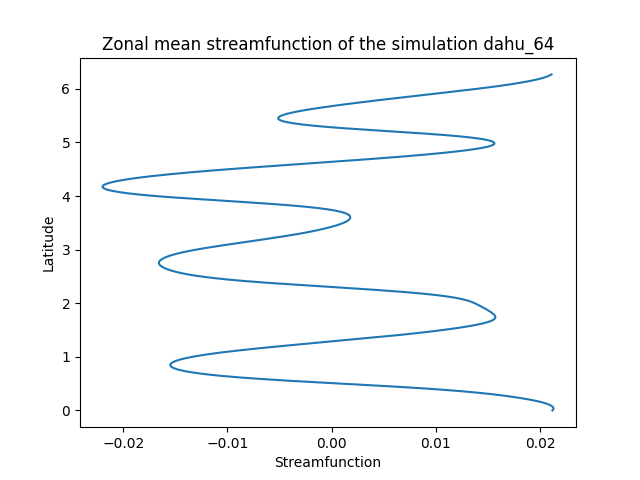

Zero crossings= [0.5031457 1.276272  2.2948353 3.423845  3.7306414 4.6387577 5.276894
 5.669593 ]
Jet size= 0.5829126834869385
Rhines length= 0.8180598107445457
Domain Size= 6.2709136


ValueError: Arrays chunk sizes are unknown: (nan,)

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [44]:
#plotting the zonnaly averaged stream function with respect to the latitude

psi_zonal_mean = np.mean(psi_data, axis=2)
psi_zonal_mean_temp = np.mean(psi_zonal_mean, axis=0)



plt.figure()
plt.plot(psi_zonal_mean_temp,y)
plt.xlabel('Streamfunction')
plt.ylabel('Latitude')
plt.title('Zonal mean streamfunction of the simulation '+str(simu_name)) 
plt.savefig('./figures/jets/psi_zonal_mean_'+str(simu_name)+'.png')   
plt.show()

zero_crossings = np.where(np.diff(np.sign(psi_zonal_mean_temp)))[0] # Find the zero crossings
print("Zero crossings=",y[zero_crossings])
jet_size=(y[zero_crossings][1]-y[zero_crossings][0]+y[zero_crossings][-1]-y[zero_crossings][-2])/2
print("Jet size=",jet_size) 

#Me Compare witrh the Rhines lengh
epsilon=sigma_f**2
print("Rhines length=",np.pi*2/(beta**0.5/(epsilon/r)**(1/4)))
print("Domain Size=",Lx)    
indices=np.arange(zero_crossings[0],zero_crossings[1]+1,1)
plt.figure()
plt.imshow(psi_zonal_mean[:,indices],cmap='jet')
plt.show()

plt.figure()
plt.plot(psi_zonal_mean_temp[indices],y[indices])
plt.xlabel('Streamfunction')
plt.ylabel('Latitude')
plt.title('Zonal mean streamfunction of the simulation '+str(simu_name)) 
plt.savefig('./figures/jets/psi_zonal_mean_'+str(simu_name)+'.png')   
plt.show()

(226,)


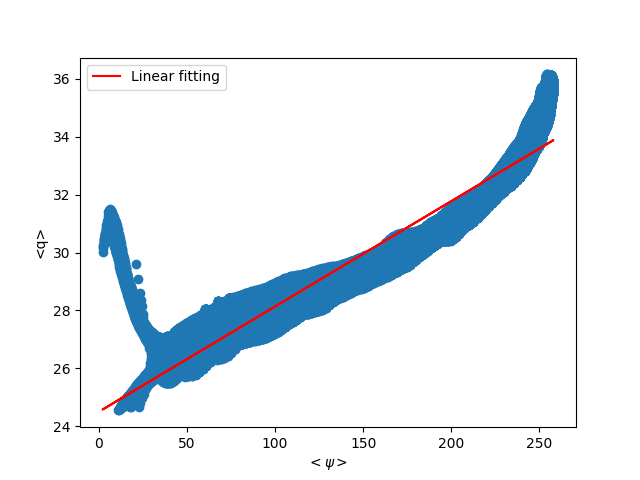

(483, 483)


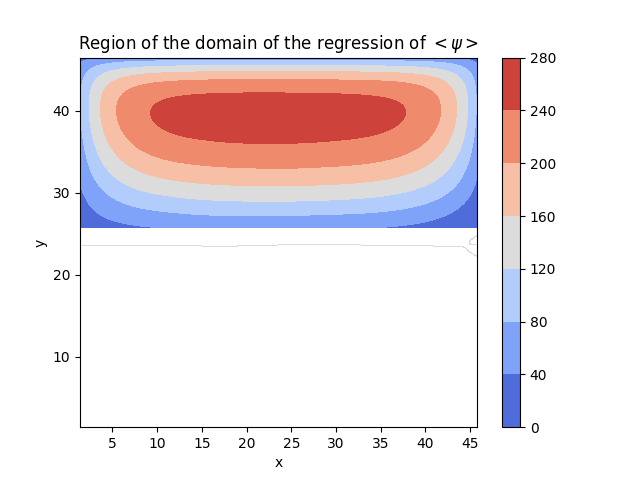

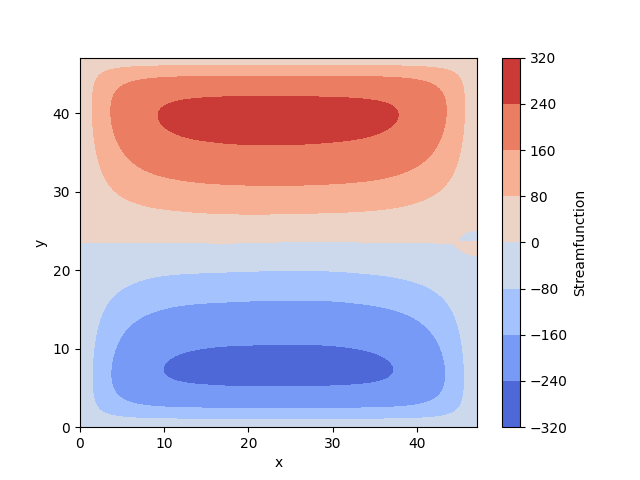

In [ ]:
#finding the indices where psi is above 30% of the maximum value
psi_max=np.max(psi_zonal_mean_temp)

indices=np.where(psi_zonal_mean_temp>0.2*psi_max)


#Finding the lattitude of psi at the extremity of the jet
y_max=y[indices[0]]


#We plot the temporal mean streamfunction  and the temporal mean q
startt=0

#selecting an indice to avoid the boundary
indice_dep=int(0.03*nx)

#Jet area.
X_jet,Y_jet=np.meshgrid(x[indice_dep:-indice_dep],y[indices[0]])
psi_jet=psi_zonal_mean_temp[indices]
print(y[indices[0]].shape)

q_mean_jet = np.mean(q[startt:,0,indices[0],indice_dep:-indice_dep],axis=0)
psi_mean_jet= np.mean(psi[startt:,0,indices[0],indice_dep:-indice_dep],axis=0)
pol=np.polyfit(psi_mean_jet.flatten(),q_mean_jet.flatten()+beta*Y_jet.flatten(),1)


plt.figure()
plt.scatter(psi_mean_jet,q_mean_jet+beta*Y_jet)
plt.plot(psi_mean_jet.flatten(),pol[0]*psi_mean_jet.flatten()+pol[1],label='Linear fitting',color='red')
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.legend()
plt.savefig('./figures/jets/linearfit_jet'+str(simu_name)+'.png')
plt.show()

print(q_mean.shape)
plt.figure()
plt.contourf(X,Y,psi_mean,levels=[-0.008,0.008],cmap='coolwarm')
plt.contourf(X_jet,Y_jet,psi_mean_jet,cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Region of the domain of the regression of '+r'$<\psi>$')
plt.savefig('./figures/jets/psi_mean_jet_'+str(simu_name)+'.png')
plt.show()

X_tot,Y_tot=np.meshgrid(x,y)
plt.figure()
plt.contourf(X_tot,Y_tot,np.mean(psi[:,0,:,:],axis=0),cmap='coolwarm')
#plt.contourf(X_jet,Y_jet,psi_mean_jet,cmap='coolwarm')
cb=plt.colorbar()
cb.set_label('Streamfunction')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Region of the domain of the regression of '+r'$<\psi>$')
plt.savefig('./figures/jets/psi_mean'+str(simu_name)+'.png')
plt.show()


In [ ]:
# u,v=op.calc_uv(psi_data,dx,bc_fac=bc_fac)

# plt.figure()
# plt.imshow(np.mean(u[:,:,:]**2+v**2,axis=0))
# plt.colorbar()